In [5]:
import os
import numpy as np
import pandas as pd

In [6]:
import log_file_reader
import dir_filter

In [16]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.14.0


In [122]:
# path_to_log_files_directory = "/Users/arif/UNR/dnn/NeuralNets/AdaptiveGridFTPClient/logs/"
path_to_log_files_directory = "/home/marifuzzaman/Downloads/NeuralNets/AdaptiveGridFTPClient/logs/"

## Data Collection

In [149]:
df = pd.DataFrame({})

dir_paths = dir_filter.get_dir_paths(path_to_log_files_directory)
        
for i, path in enumerate(dir_paths):
    path = os.path.join(path_to_log_files_directory, path)
    dir_paths[i] = path
        
for dir_path in dir_paths:
    if 'freq' in dir_path.split('/'):
        continue
           
    files = [f for f in os.listdir(dir_path)]
            
    for file in files:
        try:
            if ".csv" in file:
                continue
                    
            file_path = os.path.join(dir_path, file)
            seconds, throughputs = log_file_reader.get_all_data(file_path)
                
            if len(throughputs) == 0 or sum(throughputs) == 0:
                continue
            
            if 'pronghorn' in file_path:
                net_name = 'pronghorn'
            elif 'dtns' in file_path:
                net_name = 'dtns'
            elif 'esnet' in file_path:
                net_name = 'esnet'
            elif 'comet' in file_path or 'sc' in file_path:
                net_name = 'xsede'
            else:
                net_name = np.nan
            
            data = {
                "file_name": [file],
                "network_name": [net_name]
            }

            for i in range(len(throughputs)):
                key = 'p' + str(i+1)
                data[key] = [throughputs[i]]

            data['mean_throughput'] = [np.mean(throughputs)]
            data['median_throughput'] = [np.median(throughputs)]
            data['stdv_throughput'] = [np.std(throughputs)]
                    
            temp_df = pd.DataFrame(data)
            df = df.append(temp_df, ignore_index=True, sort=False)
        except Exception as e:
            file_path = os.path.join(dir_path, file)
            print("{0}: {1}".format(file_path, e))


In [151]:
# df.to_csv("network_data_all.csv")
df.count()
# df = pd.read_csv("network_data.csv")

file_name            102895
network_name         102815
p1                   102895
p2                   102895
p3                   102860
p4                   102841
p5                   102808
p6                   102793
p7                   102760
p8                   102727
p9                   102674
p10                  102492
p11                  100247
p12                   99495
p13                   99040
p14                   96829
p15                   94614
p16                   93660
p17                   91847
p18                   88739
mean_throughput      102895
median_throughput    102895
stdv_throughput      102895
p19                   86724
p20                   84687
p21                   82637
p22                   80637
p23                   78730
p24                   76797
p25                   75035
p26                   73444
p27                   71678
p28                   68850
p29                   66945
p30                   65664
dtype: int64

In [152]:
df.network_name.value_counts()

xsede        74261
dtns         19205
esnet         6849
pronghorn     2500
Name: network_name, dtype: int64

In [263]:
data = df[df.network_name=='xsede'][['p2', 'p3', 'p4', 'p5', 'p6', 'mean_throughput']]

In [265]:
data.dropna(inplace=True)
data = data[data>100].dropna()
data.count()

p2                 59427
p3                 59427
p4                 59427
p5                 59427
p6                 59427
mean_throughput    59427
dtype: int64

## Pairwise Relationships

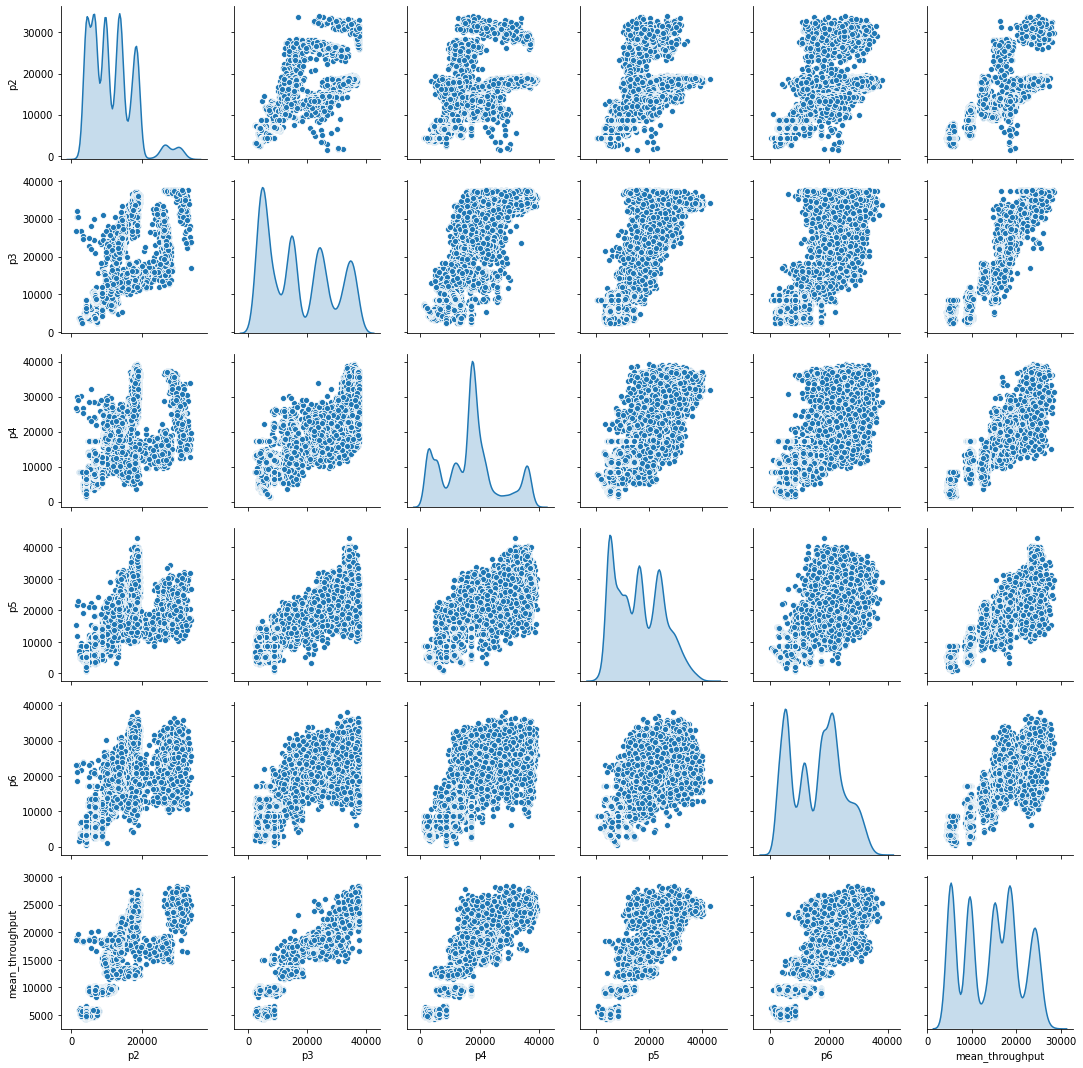

In [246]:
sns.pairplot(data[["p2", "p3", "p4", "p5", "p6", "mean_throughput"]], diag_kind="kde")
plt.show()

## Train and Test Data

In [266]:
train_dataset = data.sample(frac=0.8,random_state=0)
test_dataset = data.drop(train_dataset.index)

In [267]:
train_stats = train_dataset.describe()
train_stats.pop("mean_throughput")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
p2,47542.0,735.500284,621.203328,100.663296,287.309824,587.202560,984.612864,9569.304576
p3,47542.0,2552.096621,2166.552117,100.663296,1090.519040,2042.626048,3175.088128,23932.698624
p4,47542.0,2510.447319,2203.716884,100.663296,1096.810496,1983.905792,3078.619136,25165.824000
p5,47542.0,2593.013229,2017.713979,100.663296,1241.513984,2105.540608,3256.877056,24496.832512
p6,47542.0,2895.624340,2196.406118,100.663296,1438.646272,2277.507072,3590.324224,23569.891328


In [268]:
train_labels = train_dataset.pop('mean_throughput')
test_labels = test_dataset.pop('mean_throughput')

## Normalization

In [269]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## Model

In [270]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [271]:
model = build_model()
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 64)                384       
_________________________________________________________________
dense_49 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


## Training

In [90]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [91]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,260567.032831,323.330444,260566.953125,238130.027931,310.080139,238130.062500,995
996,260863.941192,322.598236,260863.937500,240352.575033,316.781677,240352.531250,996
997,260147.386164,321.818024,260147.390625,241275.752864,317.760590,241275.703125,997
998,259492.723500,322.080627,259492.812500,247385.201227,324.511047,247385.140625,998
999,259980.872880,322.916016,259980.906250,239347.859974,316.296753,239347.812500,999


<Figure size 432x288 with 0 Axes>

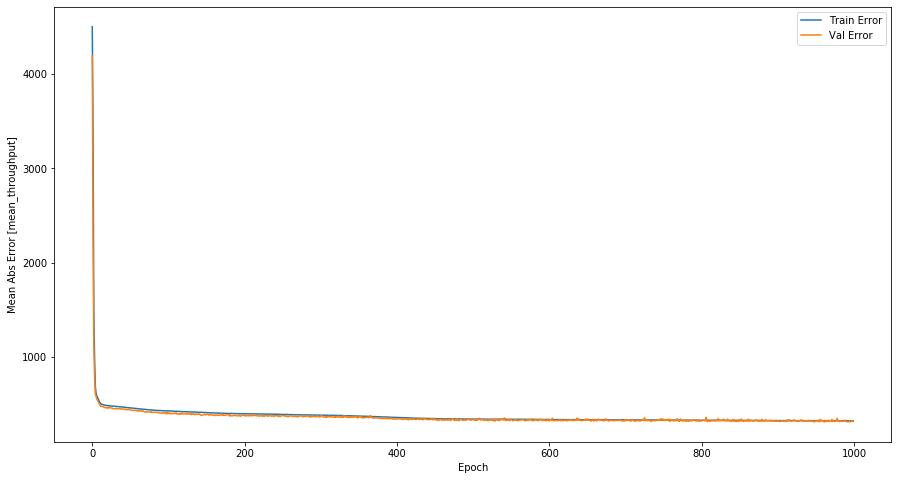

<Figure size 432x288 with 0 Axes>

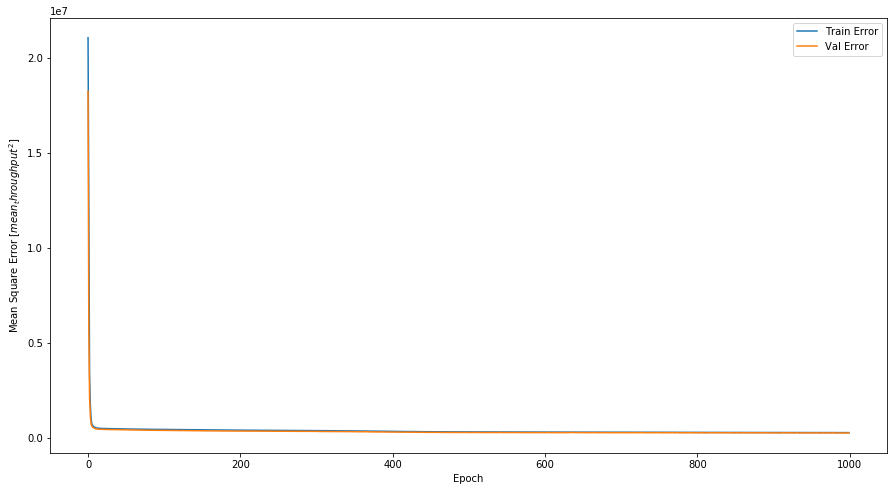

In [92]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.figure(figsize=(15,8))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [mean_throughput]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#   plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.figure(figsize=(15,8))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$mean_throughput^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#   plt.ylim([0,20])
  plt.legend()
  plt.show();


plot_history(history)

## Training - Early Terminations if Possible

In [ ]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)


....................................................................................................
....................................................................................................
.............................

## Output

In [254]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f}".format(mae))

Testing set Mean Abs Error: 697.33


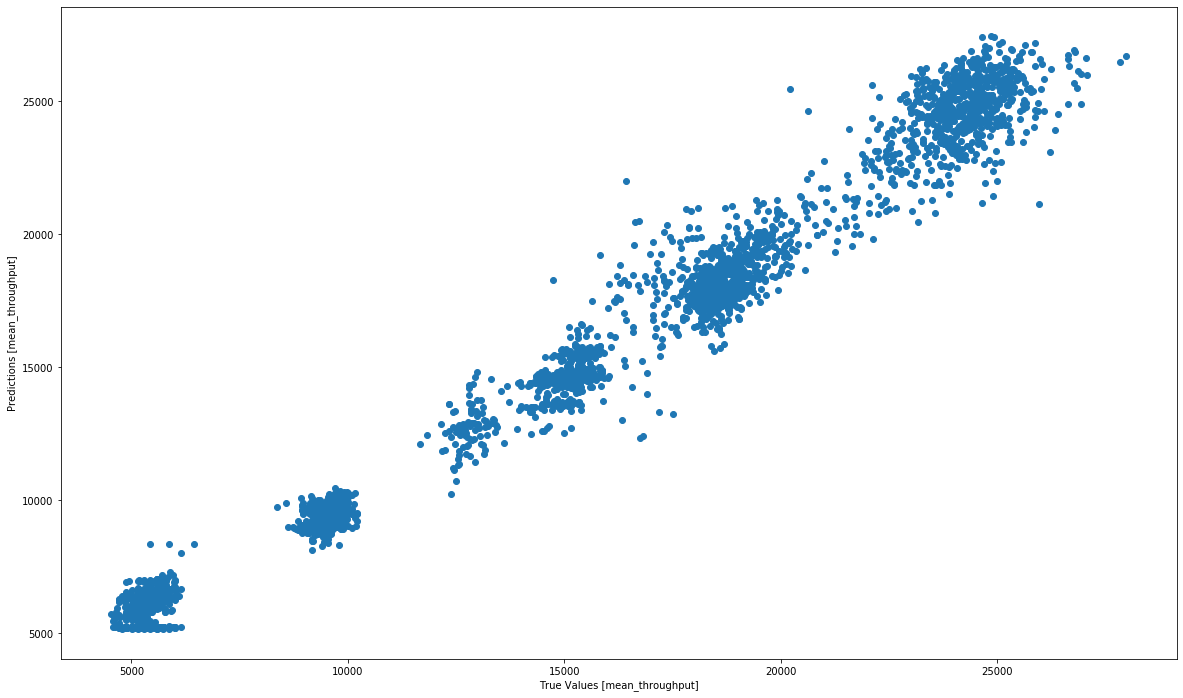

In [255]:
test_predictions = model.predict(normed_test_data).flatten()

plt.figure(figsize=(20,12))
plt.xlabel('True Values [mean_throughput]')
plt.ylabel('Predictions [mean_throughput]')
plt.scatter(test_labels, test_predictions)
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,plt.ylim()[1]])
plt.show()
# _ = plt.plot([0, 0], [-100, 100])

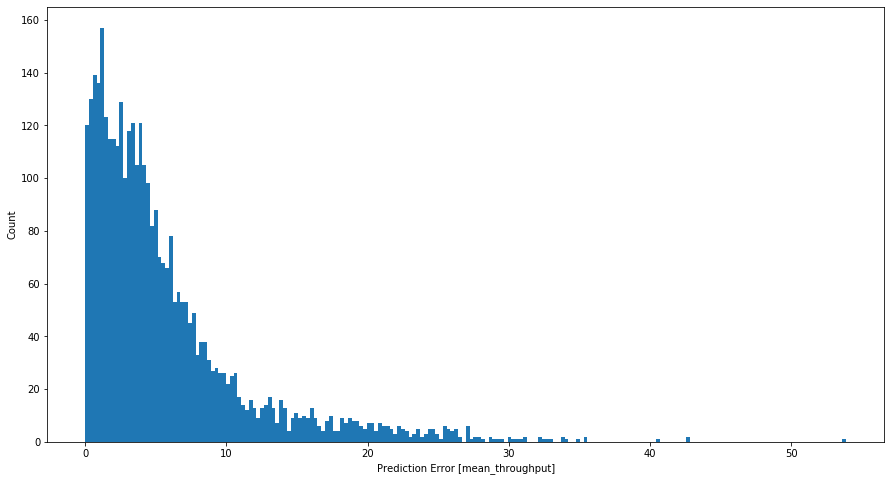

In [256]:
error = np.abs((test_predictions - test_labels)/test_labels) * 100
plt.figure(figsize=(15,8))
plt.hist(error, bins = 200)
plt.xlabel("Prediction Error [mean_throughput]")
_ = plt.ylabel("Count")

#### Error Rate

In [257]:
np.round(np.mean(error), 2)

5.73

#### Error Distribution

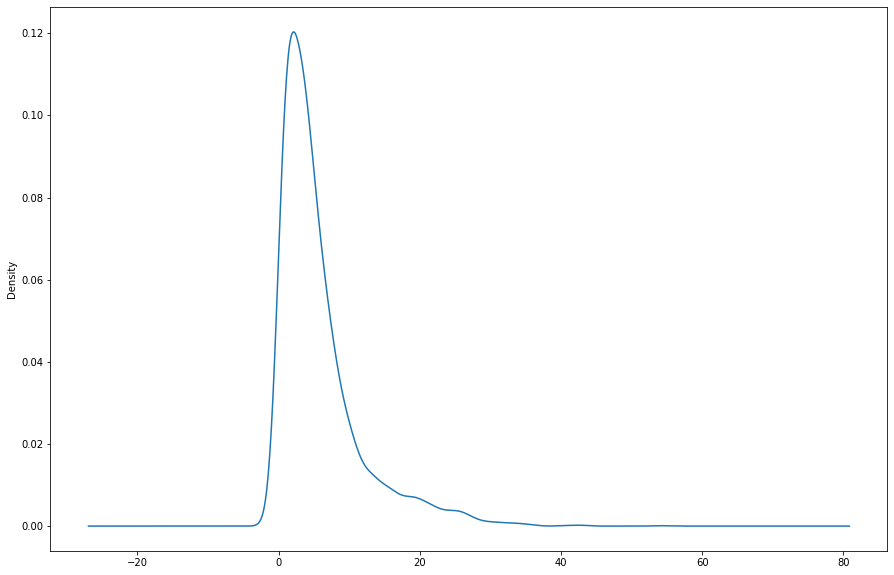

In [258]:
plt.figure(figsize=(15,10))
error.plot.kde();

#### Worst performing Data Points

In [259]:
np.mean(error[error<100])

5.733032160560147

In [260]:
data.loc[error[error>100].index,:]

,p2,p3,p4,p5,p6,mean_throughput
